<a href="https://colab.research.google.com/github/xascendent/AIEcolab/blob/main/Synthetic_Data_Generation_RAGAS_%26_LangSmith_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [2]:
!pip install -qU ragas==0.2.10

In [10]:
!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.9/326.9 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.6/306.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.8/166.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 5.0 MB/s eta 0:00:00
   ━━━━

In [3]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


We'll also want to set a project name to make things easier for ourselves.

In [4]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [5]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [6]:
!mkdir data

In [7]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31287    0 31287    0     0  82485      0 --:--:-- --:--:-- --:--:-- 82551


In [8]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70146    0 70146    0     0   490k      0 --:--:-- --:--:-- --:--:--  492k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [11]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [12]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [13]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [14]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [15]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 14, relationships: 67)

We can save and load our knowledge graphs as follows.

In [16]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 14, relationships: 67)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [17]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [18]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

A-
`SingleHopSpecificQuerySynthesizer` : Generates simple/closely tied, direct queries releated to a document.  In this example we will use 50% single hop queries.  These are typically a single-step Q&A.

`MultiHopAbstractQuerySynthesizer` : Creates a general, indirect, or abstract queries the require mulitple reasoning steps.  In this example we will be using 25% of these types of queries.  These are typically a big picture questions.

`MultiHopSpecificQuerySynthesizer` : Creates detailed, multi-step queries that require combing through multiple facts from the documents.  These are typically a deeper fact-linking questions.


Finally, we can use our `TestSetGenerator` to generate our testset!

In [19]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,OpenAI do what?,[Code may be the best application The ethics o...,"A year ago, OpenAI was the only organization t...",single_hop_specifc_query_synthesizer
1,What challenges do AI researchers face when ev...,[Based Development As a computer scientist and...,AI researchers face significant challenges whe...,single_hop_specifc_query_synthesizer
2,What GPT-4 do?,[Simon Willison’s Weblog Subscribe Stuff we fi...,We don’t yet know how to build GPT-4.,single_hop_specifc_query_synthesizer
3,what ai do to people jobs and why it matter so...,[easy to follow. The rest of the document incl...,People have certainly lost work to AI models—a...,single_hop_specifc_query_synthesizer
4,Wht did OpenAI kno that others didnt?,[Voice and live camera mode are science fictio...,"OpenAI's best model, GPT-4, was almost a year ...",single_hop_specifc_query_synthesizer
5,"How have multi-modal LLMs, particularly in the...",[<1-hop>\n\nthe then-new GPT-4 Turbo and $1/mT...,"In 2024, multi-modal LLMs have seen significan...",multi_hop_abstract_query_synthesizer
6,How do Alibaba's Qwen and QvQ models exemplify...,[<1-hop>\n\nI’m beginning to see the most popu...,Alibaba's Qwen and QvQ models exemplify advanc...,multi_hop_abstract_query_synthesizer
7,What advancements have Alibaba's Qwen and QvQ ...,[<1-hop>\n\nI’m beginning to see the most popu...,Alibaba's Qwen and QvQ models represent signif...,multi_hop_abstract_query_synthesizer
8,How has the development and use of ChatGPT and...,"[<1-hop>\n\nhere, but getting to that value is...","In 2024, the development and use of ChatGPT an...",multi_hop_specific_query_synthesizer
9,How does DeepSeek v3 demonstrate advancements ...,[<1-hop>\n\nit easier for a model to follow th...,"DeepSeek v3, a 685B parameter model, showcases...",multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [20]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [21]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What contributions has Anthropic made to the d...,[Code may be the best application The ethics o...,Anthropic has produced better-than-GPT-3 class...,single_hop_specifc_query_synthesizer
1,How do LLMs handle the grammar of languages li...,[Based Development As a computer scientist and...,The grammar rules of programming languages lik...,single_hop_specifc_query_synthesizer
2,What were the significant developments and cha...,[Simon Willison’s Weblog Subscribe Stuff we fi...,"In 2023, Large Language Models (LLMs) were rec...",single_hop_specifc_query_synthesizer
3,How was the Django SQL Dashboard utilized in t...,[easy to follow. The rest of the document incl...,The Django SQL Dashboard was used to generate ...,single_hop_specifc_query_synthesizer
4,How has OpenAI influenced the development of L...,[<1-hop>\n\nCode may be the best application T...,OpenAI has played a significant role in the de...,multi_hop_abstract_query_synthesizer
5,How does the quality and ethics of training da...,[<1-hop>\n\nCode may be the best application T...,The quality of training data is crucial in the...,multi_hop_abstract_query_synthesizer
6,How does the ethics of AI training data impact...,[<1-hop>\n\nCode may be the best application T...,The ethics of AI training data significantly i...,multi_hop_abstract_query_synthesizer
7,What are the implications of model training co...,[<1-hop>\n\nCode may be the best application T...,The development of Large Language Models (LLMs...,multi_hop_abstract_query_synthesizer
8,How do the advancements in GPT-4 and GPT-4o re...,[<1-hop>\n\nAnother common technique is to use...,The advancements in GPT-4 and GPT-4o highlight...,multi_hop_specific_query_synthesizer
9,What are the advancements and challenges assoc...,[<1-hop>\n\nfeed with the model and talk about...,Claude 3.5 Sonnet represents a significant adv...,multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [22]:
from langsmith import Client

client = Client()

dataset_name = "State of AI Across the Years - v2"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years v2"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [23]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [24]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [25]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [26]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [27]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

In [28]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [29]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [30]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Finally, we can set-up our RAG LCEL chain!

In [31]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [32]:
rag_chain.invoke({"question" : "What are Agents?"})

'Agents are a frustratingly vague term that generally refers to AI systems that can act on your behalf. There are two main categories of thought regarding agents: one sees them as entities that act on behalf of users, like travel agents, while the other views them as large language models (LLMs) that can use tools in a loop to solve problems. However, there is a lack of clear definitions, and many believe that true AI agents have not yet materialized in practice.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4o as our evaluation LLM for our base Evaluators.

In [33]:
eval_llm = ChatOpenAI(model="gpt-4o")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [34]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:  Does our answer do a good job of answering the question.
- `labeled_helpfulness_evaluator`: Is the submission helpful to the user / taking into the accoun the correct reference answer.
- `dope_or_nope_evaluator`: Is the submission dope (cool, rad, lit, bussin, gas, gucci, or dank.)

## LangSmith Evaluation

In [35]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'ordinary-boy-3' at:
https://smith.langchain.com/o/9c56cdc6-a010-4cc6-8290-38ac5935bd41/datasets/b3f711b2-c2f0-47ad-8283-bbaa088adfa2/compare?selectedSessions=c37a0c2c-ae35-432a-8174-9f36a673b618




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How has the development and application of Lar...,The development and application of Large Langu...,None,The development and application of Large Langu...,1,1,1,6.878566,b20598d5-bcab-4f5b-817e-f65fcfa2ba77,d50c9eae-add4-4fa7-bd64-1881ab893e59
1,How did the advancements in GPT-4 and other LL...,The advancements in GPT-4 and other LLMs in 20...,None,"In 2024, advancements in GPT-4 and other large...",1,0,1,2.354066,430094c5-00aa-47de-8f9a-33d3f95b2ca0,863ed9a5-869d-4197-882e-dec6b0c51a06
2,What are the advancements and challenges assoc...,The advancements associated with Claude 3.5 So...,None,Claude 3.5 Sonnet represents a significant adv...,1,0,0,2.731682,284907e6-433f-4ff2-a06b-02837ea8215e,cce27408-2ae2-41ca-8aa3-8ea26053a4ad
3,How do the advancements in GPT-4 and GPT-4o re...,I don't know.,None,The advancements in GPT-4 and GPT-4o highlight...,0,0,0,0.825844,f9535328-4499-4d91-982b-4e91d2f71c26,45ce114a-5415-45cf-9af2-088c632a2c69
4,What are the implications of model training co...,The context suggests that training costs for L...,None,The development of Large Language Models (LLMs...,1,1,0,3.034004,033aa2fb-79b7-4543-92be-f0ed4073bf91,c41aecd0-4357-496e-bda9-b5ea678566f2
5,How does the ethics of AI training data impact...,The ethics of AI training data impacts the dev...,None,The ethics of AI training data significantly i...,1,0,0,1.860844,c506ca40-cfd6-4c41-9e64-a8d6182df5a8,7c7065d7-89b6-4f3a-b035-03d545aac28e
6,How does the quality and ethics of training da...,The quality and ethics of training data are cr...,None,The quality of training data is crucial in the...,1,1,0,2.571359,780c1cd3-336b-498f-b215-b02d660aea99,ddd50b21-8837-4022-98da-42b7a0e2f7f4
7,How has OpenAI influenced the development of L...,OpenAI has influenced the development of Large...,None,OpenAI has played a significant role in the de...,1,0,1,3.313043,b52c9dab-0c27-4ace-9757-4a34fc1570de,6fe8e5f8-e0d6-4a69-836b-9894f8f04230
8,How was the Django SQL Dashboard utilized in t...,The Django SQL Dashboard was utilized to gener...,None,The Django SQL Dashboard was used to generate ...,1,0,1,1.699245,5944b3d6-bd74-48ed-b0e0-34c565807ac7,61011c18-5387-4980-9e7f-e04ef6ed5b37
9,What were the significant developments and cha...,"In 2023, significant developments associated w...",None,"In 2023, Large Language Models (LLMs) were rec...",1,1,0,3.235033,73dc7fdb-8fea-497f-8e84-a26c8f127b62,05822aea-15d3-4c73-ad49-fae85b024521


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [36]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [37]:
rag_documents = docs

In [38]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

A- Modifying chunk size affects how well our RAG system retrieves and understands context. **Larger chunks** provide more context, increasing the chance of finding relevant information, but they can also introduce noise and overwhelm the model. **Smaller chunks** improve precision but may lose important context if split too much. The key is finding the right balance to optimize retrieval accuracy and response quality.  Super large chunks could also effect overall system performance (memory issues, more tokens than a context window can use to name a few)

In [39]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

A- Model embedding is how well our RAG pipeline understands and retrieves relevent information.  A better embedding model can capture deeper meaning and relationships and improving search accuracy.  However, higher models may increase processing pipeline time and costs.  Smaller models might run faster but miss details.

In [40]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [ ]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [41]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [42]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

'Yo, so "Agents" are those elusive AI systems that are supposed to act on your behalf, kinda like a digital sidekick. But here’s the kicker: the term is super vague and people are tossing it around without a solid definition. Some folks think of them like travel agents, while others see them as LLMs using tools to solve problems. The bottom line? They’re still in the "coming soon" phase and not really running in the wild just yet. It’s a whole vibe of excitement mixed with frustration!'

Finally, we can evaluate the new chain on the same test set!

In [43]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'sparkling-judge-87' at:
https://smith.langchain.com/o/9c56cdc6-a010-4cc6-8290-38ac5935bd41/datasets/b3f711b2-c2f0-47ad-8283-bbaa088adfa2/compare?selectedSessions=4a21ae43-d872-4e83-a8b2-98a656fac1b3




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How has the development and application of Lar...,"Yo, the evolution of Large Language Models (LL...",None,The development and application of Large Langu...,1,1,1,5.100560,b20598d5-bcab-4f5b-817e-f65fcfa2ba77,47b847f6-2543-475e-8d92-c360a2ac21a5
1,How did the advancements in GPT-4 and other LL...,"Yo, the advancements in GPT-4 and other LLMs i...",None,"In 2024, advancements in GPT-4 and other large...",1,0,1,3.915434,430094c5-00aa-47de-8f9a-33d3f95b2ca0,30f35ad2-944a-4231-bb76-fbd2a518d86a
2,What are the advancements and challenges assoc...,"Yo, check it out! Claude 3.5 Sonnet is flexing...",None,Claude 3.5 Sonnet represents a significant adv...,1,0,1,4.031279,284907e6-433f-4ff2-a06b-02837ea8215e,9386f132-13e2-43b1-8af0-47a87371b3ac
3,How do the advancements in GPT-4 and GPT-4o re...,"Yo, check it out! The advancements in GPT-4 an...",None,The advancements in GPT-4 and GPT-4o highlight...,1,0,1,4.946831,f9535328-4499-4d91-982b-4e91d2f71c26,3fef52df-c9ea-451b-b0a2-a2e10c90f557
4,What are the implications of model training co...,"Yo, the training costs for LLMs are dropping, ...",None,The development of Large Language Models (LLMs...,1,1,1,2.555801,033aa2fb-79b7-4543-92be-f0ed4073bf91,b419424d-58d5-443b-b863-f7e800b91889
5,How does the ethics of AI training data impact...,"Yo, the ethics around AI training data is like...",None,The ethics of AI training data significantly i...,1,0,1,1.693609,c506ca40-cfd6-4c41-9e64-a8d6182df5a8,3d1d4fbe-eed1-4397-86df-a57a8a5c1ac2
6,How does the quality and ethics of training da...,"Yo, the quality and ethics of training data ar...",None,The quality of training data is crucial in the...,1,0,1,3.637827,780c1cd3-336b-498f-b215-b02d660aea99,e13937f5-5f69-4a46-b9e7-11d1947f3ba4
7,How has OpenAI influenced the development of L...,OpenAI kicked off the LLM revolution by being ...,None,OpenAI has played a significant role in the de...,1,0,1,3.035328,b52c9dab-0c27-4ace-9757-4a34fc1570de,44283a06-b3e8-4007-aaea-a35243c9a398
8,How was the Django SQL Dashboard utilized in t...,"Yo, the Django SQL Dashboard was like the secr...",None,The Django SQL Dashboard was used to generate ...,1,0,1,1.994995,5944b3d6-bd74-48ed-b0e0-34c565807ac7,eb314fcc-3f46-4eb0-b309-1afc3436b8aa
9,What were the significant developments and cha...,"Yo, in 2023, Large Language Models (LLMs) hit ...",None,"In 2023, Large Language Models (LLMs) were rec...",1,1,1,7.266188,73dc7fdb-8fea-497f-8e84-a26c8f127b62,3cb1623a-4750-48c4-8650-cfccea2be671


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

A- We used different types of embeddings: text-embedding-3-small, and text-embedding-3-large which will make differences between the graphs.  The chunk size and overlap didn't change between the two or I would expect more changes between the graph.  The dopeness is because we told it to be in the second system prompt.

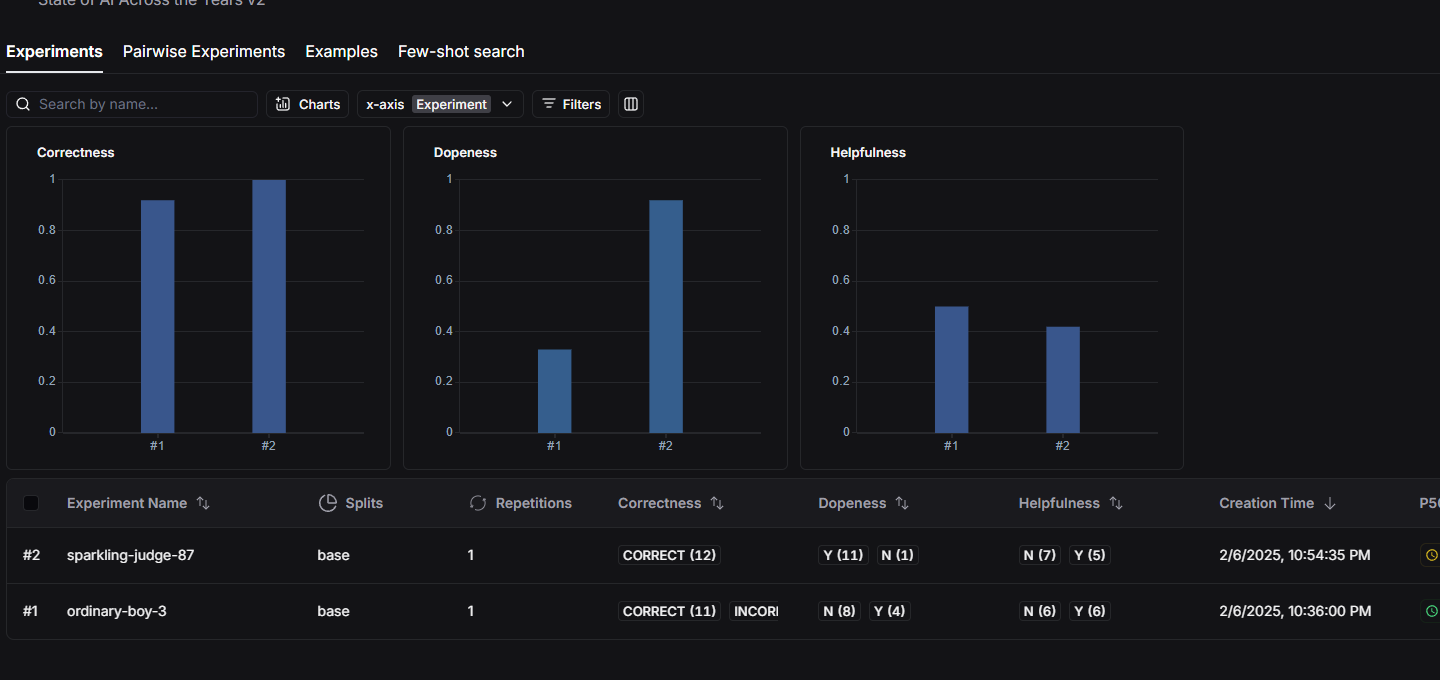